In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm
from itertools import cycle
from random import shuffle
from sklearn.model_selection import train_test_split



import torch
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import OrderedDict

from cycle_consistent_vae import Encoder, Decoder
from latent_classifier import Classifier


np.random.bit_generator = np.random._bit_generator

In [2]:
cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

MODEL_PATH = "./models/cycle_vae_06052020-030456_99.pth"
checkpoint = torch.load(MODEL_PATH)

Z_DIM = 16 #Style Dimension (Unspecified)
S_DIM = 16 # Class Dimension (Specified)

encoder = Encoder(style_dim=Z_DIM, class_dim=S_DIM)
encoder.load_state_dict(checkpoint['encoder'])

encoder.to(device)
encoder.eval()

Encoder(
  (conv_model): Sequential(
    (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU(inplace)
    (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU(inplace)
    (conv_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_3): ReLU(inplace)
    (conv_4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_4): ReLU(inplace)
  )
  (style_mu): Linear(in_features=512, out_features=16, bias=True)
  (style_logvar): Linear(in_features=512, out_features=16, bias=True)
  (class_output): Line

# Dataset processing

In [3]:
class Latent(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.encoder = encoder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][:,:,:3]
        
        return (img, self.labels[index])

In [4]:
# PATH = './processed/'
# files = os.listdir(PATH)
# data = []
# labels = []

# counter=0
# for folder in files:
#     print(counter)
#     sprites = os.listdir(PATH+folder)
#     for sprite in sprites:
#         data.append(plt.imread(PATH+folder+"/"+sprite))
#         labels.append(int(folder))
#     counter+=1

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, \
#                                                     test_size=0.33, random_state=42, \
#                                                     shuffle=True, stratify=labels )

In [6]:
# train_data = Latent(X_train, y_train)
# test_data = Latent(X_test, y_test)

In [7]:
# with open('train_latent.pkl','wb') as f:
#     pickle.dump(train_data, f)
# with open('test_latent.pkl','wb') as f:
#     pickle.dump(test_data, f)

In [8]:
t1 = pickle.load(open('train_latent.pkl','rb'))
t2 = pickle.load(open('test_latent.pkl','rb'))

In [9]:
BATCH_SIZE = 16
train_loader = DataLoader(t1,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
test_loader = DataLoader(t2,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [10]:
NUM_CLASSES=672

# Latent Classifier - Unspecified Features

In [11]:
TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

NUM_EPOCHS = 200

LEARNING_RATE = 1e-3

MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
CUDA = True

In [12]:
model = Classifier(z_dim=Z_DIM, num_classes=NUM_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [13]:
is_better = True
prev_acc = 0
name = "specified_latent_classifier"

liveloss = PlotLosses(fig_path='./figures/'+name+".png")

In [14]:
dataloaders = {'train':train_loader, 'validation':test_loader}

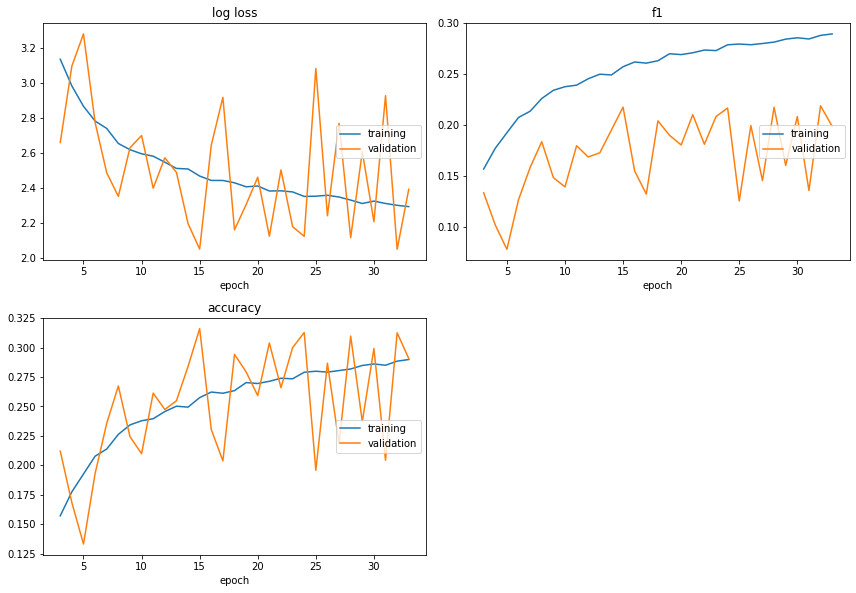

log loss:
training   (min:    2.294, max:    5.127, cur:    2.294)
validation (min:    2.051, max:    3.766, cur:    2.393)

f1:
training   (min:    0.036, max:    0.290, cur:    0.290)
validation (min:    0.047, max:    0.219, cur:    0.199)

accuracy:
training   (min:    0.037, max:    0.290, cur:    0.290)
validation (min:    0.096, max:    0.316, cur:    0.291)
Started Phase
Phase time -  50.190683126449585
Started Phase


KeyboardInterrupt: 

In [15]:
for epoch in range(NUM_EPOCHS):
    logs = {}
    t_start = time.time()
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
        model.to(device)
        
        print("Started Phase")

        running_loss = 0.0
                
        predicted_phase = torch.zeros(len(dataloaders[phase].dataset), NUM_CLASSES)
        target_phase = torch.zeros(len(dataloaders[phase].dataset))
        
        if phase == 'validation':
            
            with torch.no_grad():
                
                for (i,batch) in enumerate(dataloaders[phase]):
                    input_tensor = batch[0]
                    input_tensor = input_tensor.to(device)
                    input_tensor = torch.transpose(input_tensor, 2,3)
                    input_tensor = torch.transpose(input_tensor, 1,2)

                    _, _, latent_vector = encoder(input_tensor)

                    bs = input_tensor.shape[0]
                    target_tensor = batch[1].to(device).reshape(bs)

                    softmaxed_tensor = model(latent_vector)

                    loss = criterion(softmaxed_tensor, target_tensor.long())

                    predicted_phase[i*bs:(i+1)*bs] = softmaxed_tensor.cpu()
                    target_phase[i*bs:(i+1)*bs] = target_tensor.cpu()

                    input_tensor = input_tensor.cpu()
                    target_tensor = target_tensor.cpu()

                    running_loss += loss.detach() * bs
                
     
        else:
            
            for (i,batch) in enumerate(dataloaders[phase]):
                input_tensor = batch[0]
                input_tensor = input_tensor.to(device)
                input_tensor = torch.transpose(input_tensor, 2,3)
                input_tensor = torch.transpose(input_tensor, 1,2)

                _, _, latent_vector = encoder(input_tensor)

                bs = input_tensor.shape[0]
                target_tensor = batch[1].to(device).reshape(bs)

                softmaxed_tensor = model(latent_vector)

                loss = criterion(softmaxed_tensor, target_tensor.long())

                predicted_phase[i*bs:(i+1)*bs] = softmaxed_tensor.cpu()
                target_phase[i*bs:(i+1)*bs] = target_tensor.cpu()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                input_tensor = input_tensor.cpu()
                target_tensor = target_tensor.cpu()

                running_loss += loss.detach() * bs
    

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_predicted = torch.argmax(predicted_phase, dim=1)
        epoch_f1 = f1_score(target_phase, epoch_predicted, average = 'macro')
        epoch_accuracy = accuracy_score(target_phase, epoch_predicted)

        
        model.to('cpu')

        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        logs[prefix + 'f1'] = epoch_f1.item()
        logs[prefix + 'accuracy'] = epoch_accuracy.item()
        
        print('Phase time - ',time.time() - t_start)

    delta = time.time() - t_start
    is_better = logs['val_accuracy'] > prev_acc
    if is_better:
        prev_acc = logs['val_accuracy']
        torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'loss': logs['log loss']}, "./models/"+name+"_"+TIME_STAMP+"_"+str(logs['val_accuracy'])+".pth")


    liveloss.update(logs)
    liveloss.draw()